#  Markov chain Monte Carlo (MCMC)  
## Matropolis-Hastings Algorithm

Ransalu Senanayake

Theory: Bishop's chapter 11.2.

In [3]:
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

from sklearn.neighbors.kde import KernelDensity

In [4]:
def normal_pdf(z, mu, sigma):
    constant = 1/np.sqrt(2*np.pi*sigma**2)
    y_pdf = constant * np.exp(- ((z-mu)**2) / (2*sigma**2))
    return y_pdf

def complex_pdf(z):
    p_z = 0.4*normal_pdf(z, -3, 1) + 0.6*normal_pdf(z, 1, 1)
    return p_z 

Let's consider $p(z) = \frac{\tilde{p}(z)}{Z_p}$ where $Z_p$ is an unknown normalizing constant. 

We want to obtain samples from $p(z)$, it is not possible because it is a complicated distribution. Although it cannot be sampled, its probability density can be easily evaluated. We use a another distribution, named the proposal distribution, $q(Z)$ which can be easily sampled. 

## 1. Metropolis algorithm

There are five steps involved,
* Step 0: pick an initial sample $z_t$ and pick $q(z)$---a distribution that is simple enough to be sampled
* Step 1: draw a sample $z_m$ from $q(z)$
* Step 2: evaluate $p(z_t)$ and $p(z_m)$
* Step 3: evaluate the acceptance ration $a(z_t \rightarrow z_m) = \min(1,p(z_m)/p(z_t))$
* Step 4: draw a sample $u$ from the uniform distribution $\mathcal{U}[0,1]$
* Step 5: if $a(z_t \rightarrow z_m) > u$, keep $z_m$ and set $z_t = z_m$ (a new jump); otherwise Step 1.

Perform this $M$ times. 

The concept behind step 5 is, if the density of the new sample $z_m$ is higher than the previous sample $z_t$, it is always retained. Otherewise, sometimes it is retained and sometimes rejected. This notion of "sometimes" comes from the uniform distribution. Technically, the sample is accepted with probability $a$.

In this case we assume that $q(z_m|z_t) = q(z_t|z_m)$.

**Example 1**

True distribution: a complicated bimodal distribution

Proposal distribution: $\mathcal{N}(0,3)$

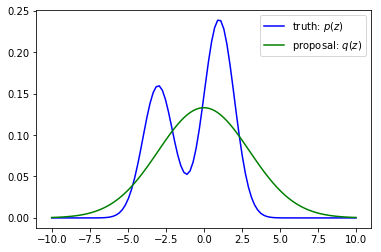

In [6]:
z = np.linspace(-10,10,100)

# We want to obtain samples from the distribution p(z) 
p = complex_pdf(z)

# Let's consider a propasal distribution q(z)
q_mu, q_sig = 0, 3
q = normal_pdf(z, q_mu, q_sig)

#Plot
pl.plot(z, p, c='b', label='truth: '+r'$p(z)$')
pl.plot(z, q, c='g', label='proposal: '+r'$q(z)$')
pl.legend()

In [7]:
def metropolis(q, p, M=100, z_0=0):
    keep = [] #accepted samples
    track = [] #keep track of all steps for visualization purposes

    z_t = z_0 # Step 0: pick an initial position

    for i in range(M):    
        z_m = q() # Step 1: draw a sample from q

        p_z_m = p(z_m) # Step 2: compute the density
        p_z_t = p(z_t) # Step 2: compute the density

        A = np.minimum(1, p_z_m/p_z_t) # Step 3: calculate the accpetance probability

        u = np.random.uniform(low=0, high=1, size=1) # Step 4: draw a sample from a uniform distribution

        track.append((z_t, p_z_t, z_m, p_z_m, u <= A))

        if u <= A: #Step 5: keep if in the region
            keep.append(z_m)
            z_t = z_m

    return np.array(keep), np.array(track)

In [10]:
def plot(track):
    M = track.shape[0]
    pl.figure(figsize=(20,5))
    pl.plot(z, p, c='b', label='truth: '+r'$p(z)$', alpha=0.5)
    pl.plot(z, q, c='g', label='proposal: '+r'$\tilde{p}(z)$', alpha=0.5)
    for m in range(M):
        if track[m,4] == True:
            col = 'm'
            pl.annotate('', xy=(track[m,2], track[m,3]), xycoords='data', 
                    xytext=(track[m,0], track[m,1]), textcoords='data',
                    arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color=col))
        else:   
            col = 'c'
            pl.annotate('', xy=(track[m,2], track[m,3]), xycoords='data', 
                     xytext=(track[m,0], track[m,1]), textcoords='data',
                     arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color=col))
        xpos = track[m,0] + (track[m,2] - track[m,0])/2
        ypos = track[m,1] + (track[m,3] - track[m,1])/2
        pl.text(xpos, ypos+5e-3, str(m), color=col)
    pl.scatter(track[:,2], np.zeros(track.shape[0]), c=track[:,4], s=100,  marker='|', cmap='cool')
    cbar = pl.colorbar()
    cbar.ax.get_yaxis().labelpad = 30
    cbar.ax.set_ylabel('accepted-rejected samples', rotation=270, fontsize=13)

Let's consider 10 samples.

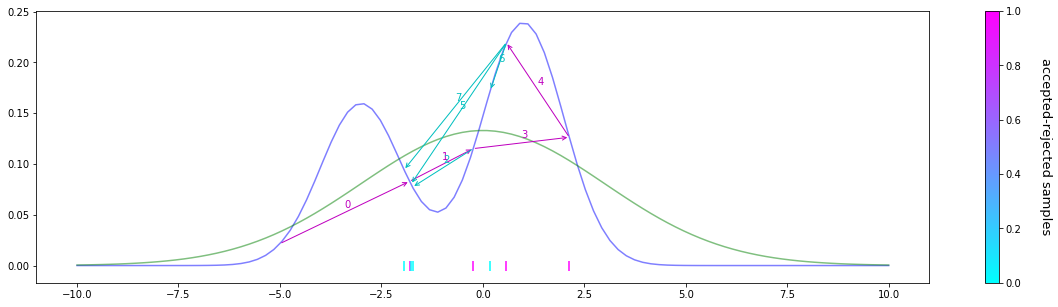

In [15]:
def proposal():
    return np.random.normal(loc=q_mu, scale=q_sig, size=1)[0]

M = 8
keep, track = metropolis(q=proposal, p=complex_pdf, M=M, z_0=-5)
plot(track)

Now, let's use 1000 samples.

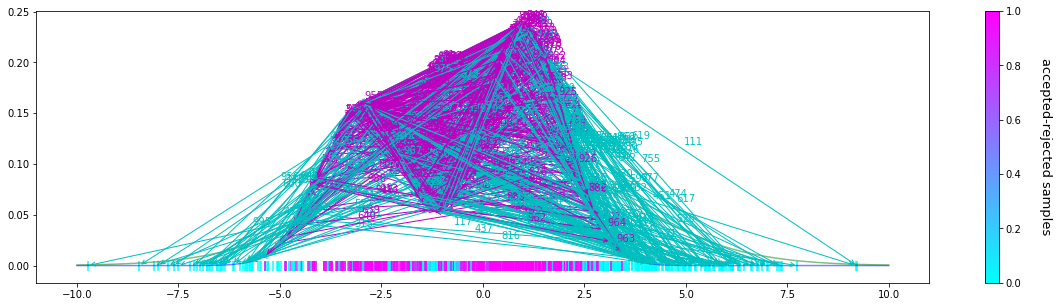

In [19]:
M = 1000
keep, track = metropolis(q=proposal, p=complex_pdf, M=M, z_0=-5)
plot(track)

Acceptance rate = 58.5%


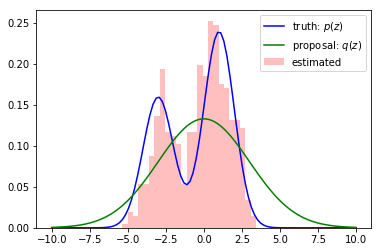

In [20]:
pl.plot(z, p, c='b', label='truth: '+r'$p(z)$')
pl.plot(z, q, c='g', label='proposal: '+r'$q(z)$')
pl.hist(keep, bins=25, normed=1, facecolor='r', alpha=0.25, label='estimated')
pl.legend()

print('Acceptance rate = {}%'.format(np.round(np.sum(track[:,4])/M*100,1)))

**Example 2**

True distribution: a complicated bimodal distribution (same as in Example 1)

Proposal distribution: a narrow distribution $\mathcal{N}(-1,0.5)$. This is a bad proposal distribution.

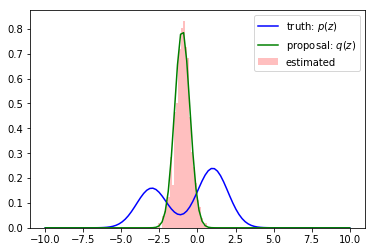

In [21]:
q_mu, q_sig = -1, 0.5

def proposal():
    return np.random.normal(loc=q_mu, scale=q_sig, size=1)[0]

keep, track = metropolis(q=proposal, p=complex_pdf, M=1000, z_0=-5)

pl.plot(z, p, c='b', label='truth: '+r'$p(z)$')
pl.plot(z, normal_pdf(z, q_mu, q_sig), c='g', label='proposal: '+r'$q(z)$')
pl.hist(keep, bins=25, normed=1, facecolor='r', alpha=0.25, label='estimated')
pl.legend()

**Example 3**

True distribution: a 2D Gaussin distribution $\mathcal{N}([0,0],[1, 0.95; 0.95, 1])$.

Proposal distribution: an isotropic distribution $\mathcal{N}([0,0],[1, 0; 0, 1])$.

In [22]:
import scipy.stats as st

Acceptance rate = 27.5%


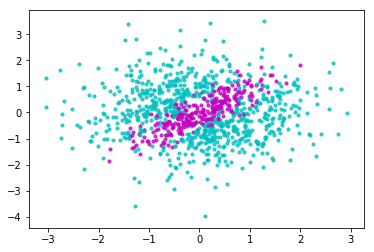

In [24]:
def proposal():
    return np.random.normal(size=2, loc=0, scale=1)

def dist(z):
    return st.multivariate_normal.pdf(z, mean=np.array([0, 0]), cov=np.array([[1, 0.95], [0.95, 1]]))

M = 1000

keep, track = metropolis(q=proposal, p=dist, M=M, z_0=np.array([0,0]))

cnt = 0
for m in range(M):
    acc = track[:,4][m][0]
    if acc == True:
        col = 'm'
        cnt += 1
    else:
        col = 'c'
    pl.scatter(track[:,2][m][0], track[:,2][m][1], s=10, c=col, alpha=0.75)
    
print('Acceptance rate = {}%'.format(np.round(cnt/M*100,1)))

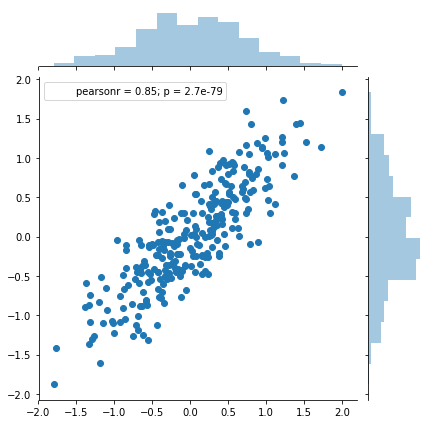

In [25]:
import seaborn as sns
sns.jointplot(keep[:, 0], keep[:, 1])

## 2. Metropolis-Hasting algorithm